In [1]:
import os
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.utils import shuffle  
from tensorflow.python.ops.numpy_ops import np_config
from itertools import product
np_config.enable_numpy_behavior()
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from scipy.stats import spearmanr
from scipy.stats import ks_2samp 


from IPython.display import clear_output

from numpy.linalg import cholesky

In [2]:
print(tf.__version__)

2.11.0


In [3]:
!wget "https://www.1001fonts.com/download/latin-modern-roman.zip"
!mkdir Font
!unzip latin-modern-roman.zip -d Font

import matplotlib.font_manager as fm
import matplotlib

# fetch the name of font that was installed
path = "Font"
fontprop = fm.FontProperties(fname=path)

matplotlib.rcParams['font.family'] = fontprop.get_family()

clear_output()

In [4]:
tf.keras.backend.set_floatx('float64')

In [5]:
tf.keras.backend.floatx()

'float64'

The following cell to be used if we want to clone the code in the repo

In [6]:
# !rm -r {'PHD_Code_test'}
!rmdir /S /Q {'PHD_Code_test'}

!git clone https://github.com/Lolillosky/PHD_Code.git PHD_Code_test

import sys
sys.modules.pop
sys.path.insert(0,'PHD_Code_test')

clear_output()

In [7]:
PATH_DATA = "DATA/"
PATH_FIGS = "FIGS/"
PATH_MODELS = "MODELS_TEST/"

# PATH_DATA = "/content/drive/MyDrive/PHD/Work PHD/CODE/market_risk_new/DATA/"
# PATH_FIGS = "/content/drive/MyDrive/PHD/Work PHD/CODE/market_risk_new/FIGS/"
# PATH_MODELS = "/content/drive/MyDrive/PHD/Work PHD/CODE/market_risk_new/MODELS_TEST/"

In [6]:
import sys
# PHD Code will contain your repo
sys.path.append(r'PHD_Code') 
# sys.path.append(r'PHD_Code_test')

import sys
sys.modules.pop

import Option_formulas
import Miscellanea
import Deep_learning_models

In [7]:

Option_formulas.BlackTF(1.0,1.0,1.0,0,0.2,True)

<tf.Tensor: shape=(), dtype=float32, numpy=0.07965565>

In [14]:
hist_data = pd.read_excel(PATH_DATA + 'Hist_data.xlsx', index_col='Dates')

display(hist_data.head(3))
display(hist_data.tail(3))

,Apple_Spot,Apple_Vol,IBM_Spot,IBM_Vol,JMP_Spot,JPM_Vol
Dates,,,,,,
2010-01-01,7.526,37.458,125.0310,23.275,41.67,35.088
2010-01-04,7.643,37.428,126.5115,23.198,42.85,34.045
2010-01-05,7.656,38.004,124.9832,23.318,43.68,33.323


,Apple_Spot,Apple_Vol,IBM_Spot,IBM_Vol,JMP_Spot,JPM_Vol
Dates,,,,,,
2022-12-06,142.91,34.215,147.50,24.998,131.59,29.305
2022-12-07,140.94,34.771,147.27,25.134,131.50,29.658
2022-12-08,140.94,34.771,147.27,25.134,131.50,29.658


In [15]:
risk_horizon = 10
hist_data_length = 250

hist_schocks = pd.DataFrame(data = np.log(hist_data.iloc[risk_horizon:].values/ hist_data.iloc[0:-risk_horizon].values),
                            index =  hist_data.index[risk_horizon:], columns = hist_data.columns) 

hist_schocks = hist_schocks.iloc[-hist_data_length:]

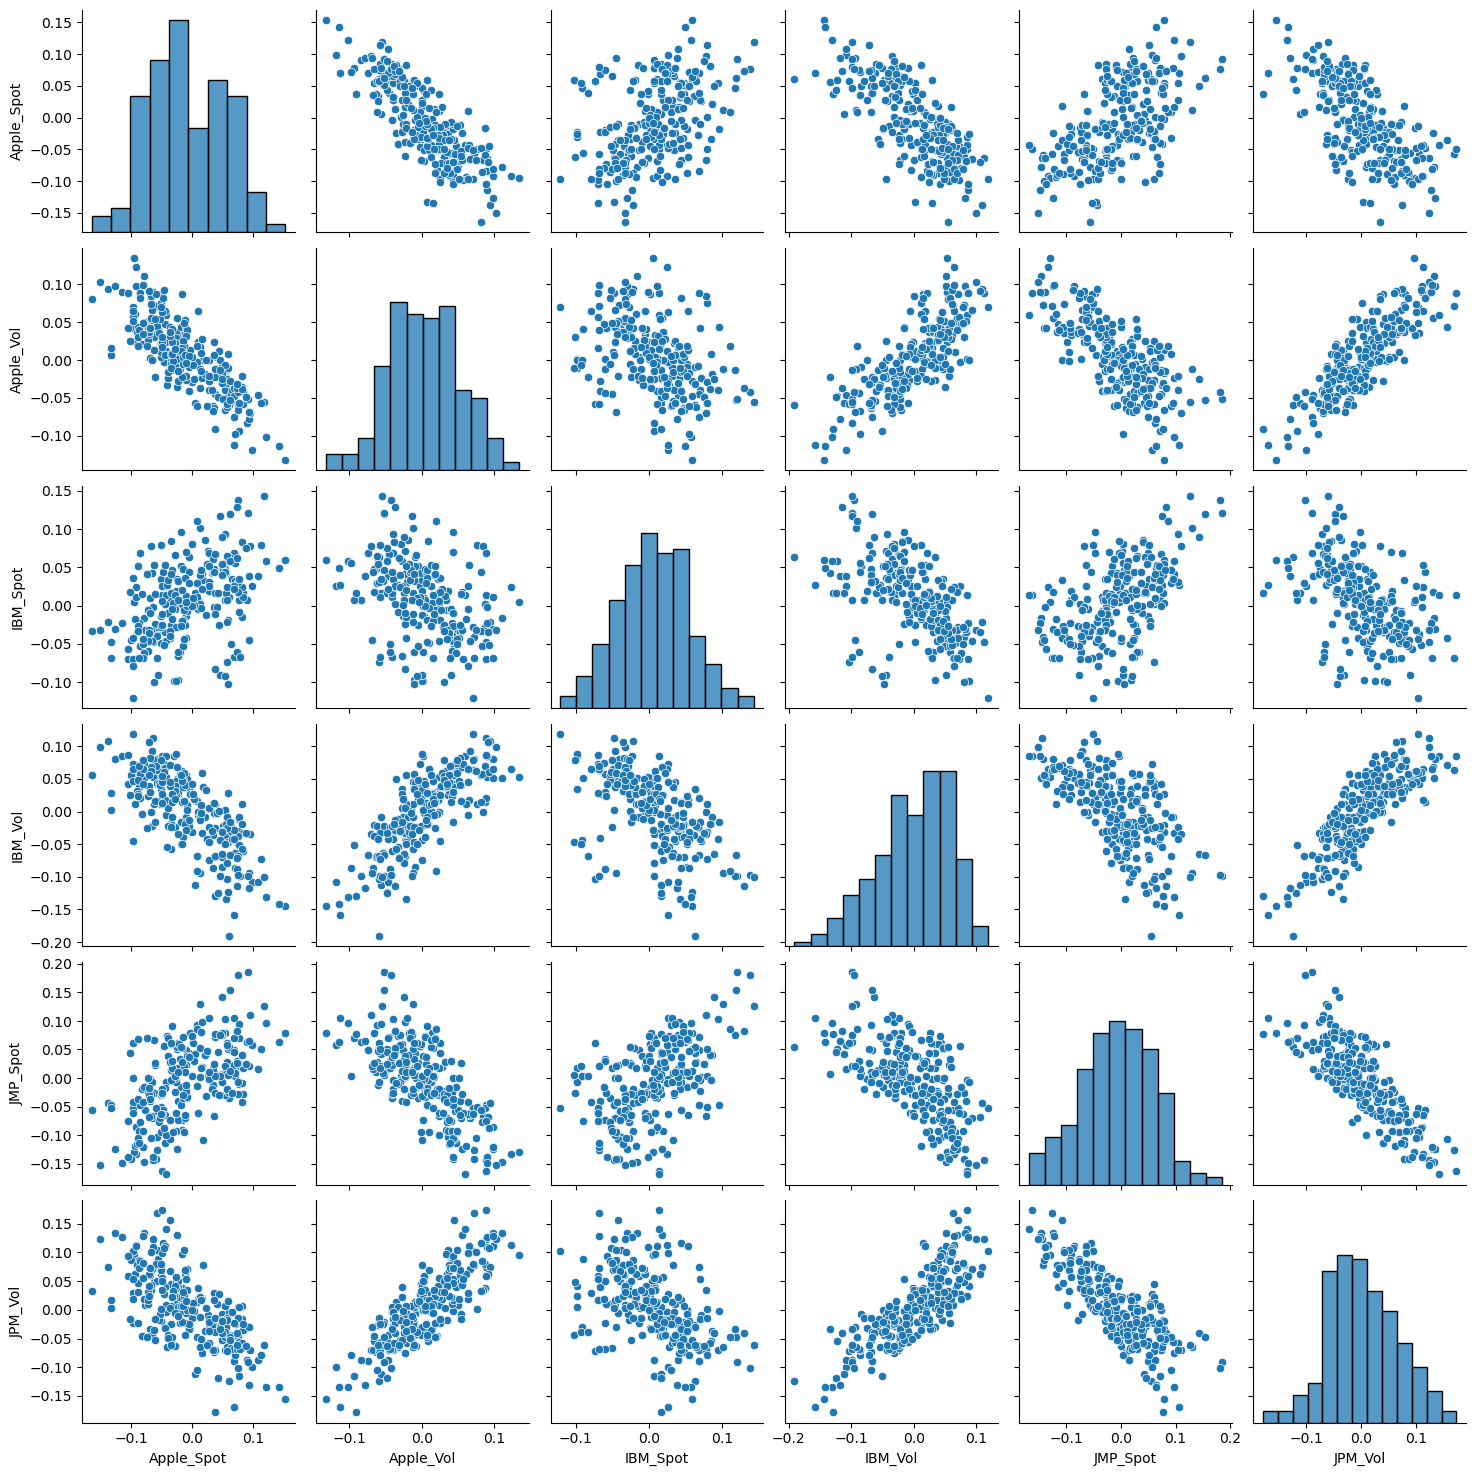

In [16]:
sns.pairplot(hist_schocks);

plt.savefig(PATH_FIGS + 'histdata.pdf')

In [17]:
from sklearn.mixture import GaussianMixture

GM = GaussianMixture(n_components= 6, random_state=1234)

GM.fit(hist_schocks)

GaussianMixture(n_components=6, random_state=1234)

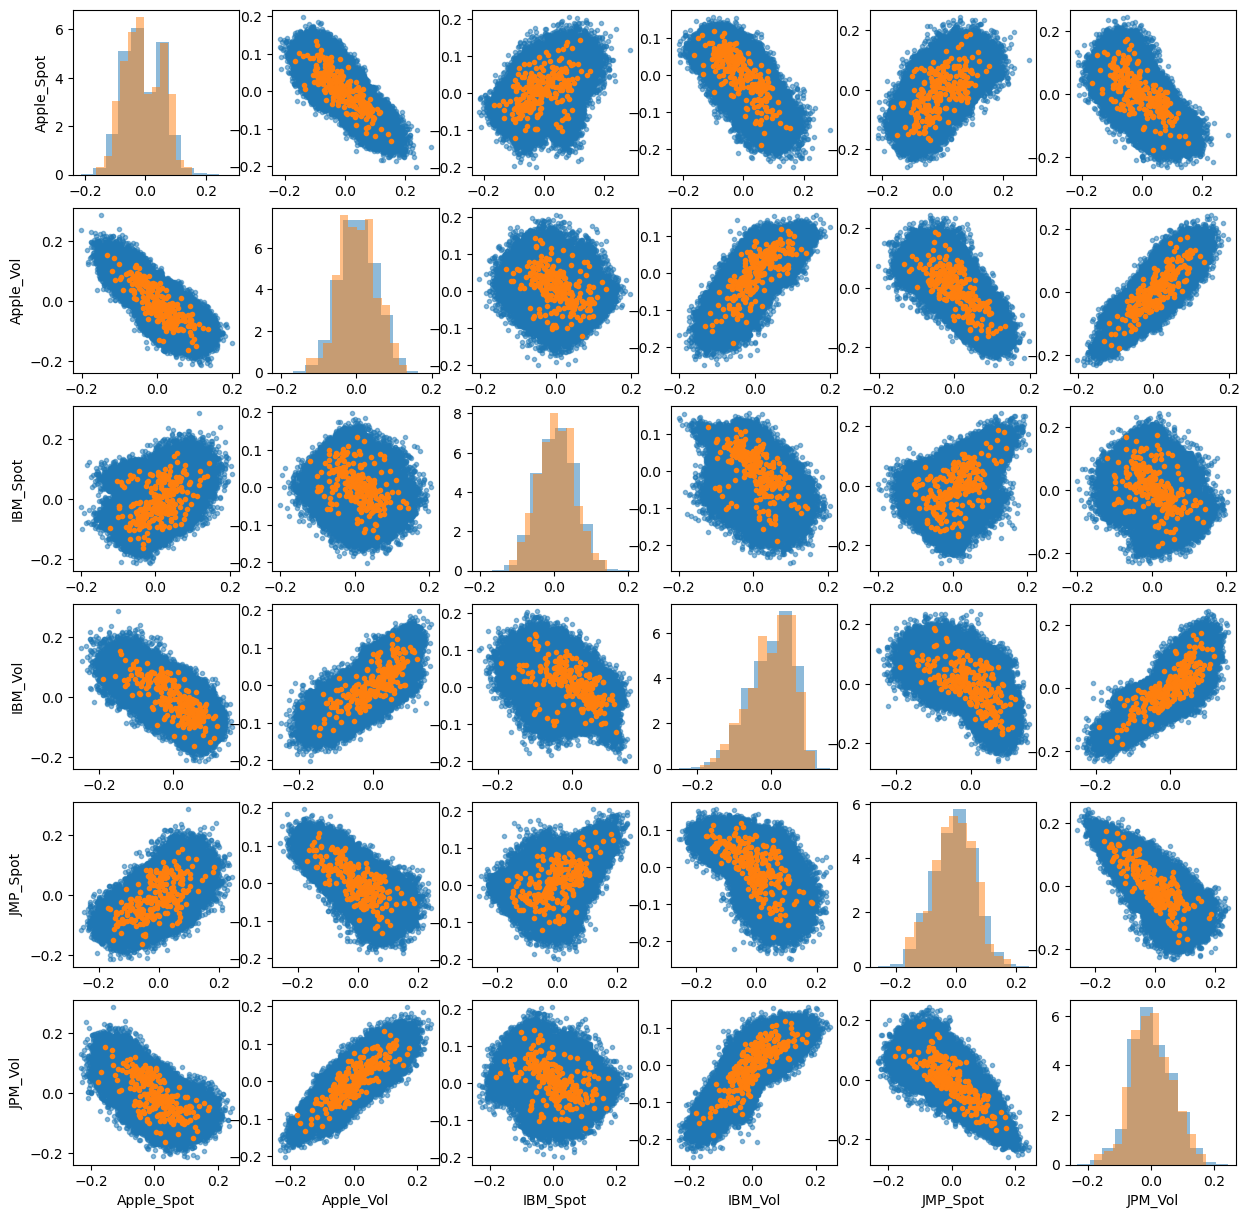

In [18]:
num_sims = 140000

np.random.seed(5678)

sim_schocks = shuffle(GM.sample(num_sims)[0])

Miscellanea.plot_schocks(6,sim_schocks,hist_schocks,hist_schocks.columns,12)     

In [19]:
TTM = 3.0
rfr = 0.01  

S_A_0, S_B_0, S_C_0 = 1.0, 1.0, 1.0

vol_A, vol_B, vol_C  = 0.2, 0.3, 0.15

K_A, K_B, K_C = 1.0, 1.0, 1.0

K = 1.0

correlations = [[1.0, 0.6, 0.4],[0.6,1.0,0.7],[0.4,0.7,1.0]]

base_scenario = np.array([S_A_0, vol_A, S_B_0, vol_B, S_C_0, vol_C])

sim_scenarios = tf.constant(base_scenario * np.exp(sim_schocks))

hist_var_scenarios = base_scenario * np.exp(hist_schocks)

chol = cholesky(correlations)

brow_ind =  np.sqrt(TTM) * np.random.normal(loc = 0.0, scale = 1.0, size = (num_sims, 3))

brow_correl = np.matmul(brow_ind, chol.T)


with tf.GradientTape() as tape:

  tape.watch(sim_scenarios)

  Spots_T = sim_scenarios[:,[0,2,4]]*tf.exp((rfr - 0.5 * sim_scenarios[:,[1,3,5]]**2)*TTM + sim_scenarios[:,[1,3,5]]* brow_correl)
  strikes = [K_A, K_B, K_C]
  payoff = tf.maximum(tf.exp(tf.reduce_mean(tf.math.log(Spots_T/strikes), axis = 1))-K,0)*tf.exp(-rfr * TTM)

  
sens = tape.gradient(payoff, sim_scenarios)



In [20]:
a = 1.0
n = 4
c = 128

Miscellanea.delete_content_of_folder(PATH_MODELS)

path = PATH_MODELS + 'alpha' + '_' + str(a) + '_cells_' + str(c) + '_hidden_' + str(n) + '/'
os.mkdir(path)

tf.keras.utils.set_random_seed(9876)

dense_model = Deep_learning_models.build_dense_model(sim_scenarios.shape[1],n,c,'relu','linear')
model = Deep_learning_models.Diff_learning_scaler(Deep_learning_models.DiffLearning(dense_model), 
                                                   alpha = a)
model.fit(sim_scenarios.numpy()[0:10000], payoff.numpy()[0:10000], 
           sens.numpy()[0:10000], batch_size= 32, epochs= 2)

model.save(path)

Epoch 1/2
313/313 [==============================] - 2s 3ms/step - loss: 1.8498
Epoch 2/2
313/313 [==============================] - 1s 3ms/step - loss: 1.7664


INFO:tensorflow:Assets written to: MODELS_TEST/alpha_1.0_cells_128_hidden_4/model\assets


INFO:tensorflow:Assets written to: MODELS_TEST/alpha_1.0_cells_128_hidden_4/model\assets


In [22]:


model_saved = Deep_learning_models.Diff_learning_scaler.open(path)

In [21]:
model.predict(sim_scenarios.numpy()[0:1])

1/1 [==============================] - 0s 94ms/step


{'y': array([0.10458062]),
 'sens': array([[0.13044022, 0.30960501, 0.22505861, 0.17847548, 0.18473383,
         0.20915141]])}

In [23]:
model_saved.predict(sim_scenarios.numpy()[0:1])

1/1 [==============================] - 0s 54ms/step


{'y': array([0.10458062]),
 'sens': array([[0.13044022, 0.30960501, 0.22505861, 0.17847548, 0.18473383,
         0.20915141]])}

In [21]:
Miscellanea.delete_content_of_folder(PATH_MODELS)

path = PATH_MODELS + 'Early' + '/'
os.mkdir(path)

valid_data = dict()

valid_data['X_val'] = sim_scenarios.numpy()[100000:120000]
valid_data['y_val'] = payoff.numpy()[100000:120000]
valid_data['dydX_val'] = sens.numpy()[100000:120000]
valid_data['patience'] = 5


tf.keras.utils.set_random_seed(9876)

dense_model = Deep_learning_models.build_dense_model(sim_scenarios.shape[1],n,c,'relu','linear')
model_early = Deep_learning_models.Diff_learning_scaler(Deep_learning_models.DiffLearning(dense_model), 
                                                   alpha = a)
hist = model_early.fit(sim_scenarios.numpy()[0:100000], payoff.numpy()[0:100000], 
            sens.numpy()[0:100000], batch_size= 32, epochs= 30, validation_data = valid_data)

model_early.save(path)


TypeError: fit() got an unexpected keyword argument 'validation_data'

In [21]:
np.mean((model_early.predict(sim_scenarios.numpy()[100000:120000])['y']-payoff.numpy()[100000:120000])**2)



625/625 [==============================] - 1s 1ms/step


0.04834398560047186

625/625 [==============================] - 1s 1ms/step


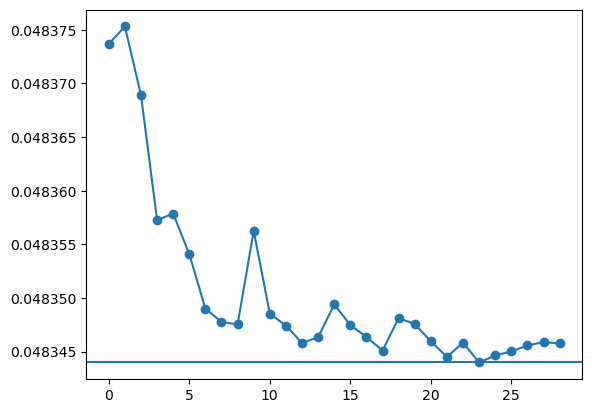

In [33]:
plt.plot(hist.history['val_Myval_Loss'], '-o')
plt.axhline(np.mean((model_early.predict(sim_scenarios.numpy()[100000:120000])['y']-payoff.numpy()[100000:120000])**2))

In [23]:
np.argmin(hist.history['val_Myval_Loss'])

23

In [24]:
model_early_saved = Deep_learning_models.Diff_learning_scaler.open(path)

In [34]:
 

model_early.predict(sim_scenarios.numpy()[0:1])

1/1 [==============================] - 0s 11ms/step


{'y': array([0.1012968]),
 'sens': array([[0.16082405, 0.12555089, 0.15791905, 0.13197239, 0.16147555,
         0.15758667]])}

In [35]:
model_early_saved.predict(sim_scenarios.numpy()[0:1])

1/1 [==============================] - 0s 43ms/step


{'y': array([0.10505365]),
 'sens': array([[0.13325624, 0.11661611, 0.13693905, 0.10700351, 0.13338663,
         0.1081624 ]])}

625/625 [==============================] - 1s 1ms/step


(array([  1.,   3.,   5.,   6.,  10.,  15.,  30.,  40.,  76.,  89., 142.,
        204., 242., 271., 331., 385., 422., 425., 408., 462., 443., 422.,
        420., 390., 396., 407., 389., 369., 370., 376., 400., 492., 484.,
        508., 540., 568., 568., 582., 610., 569., 525., 524., 457., 461.,
        401., 352., 365., 296., 299., 272., 228., 222., 211., 193., 179.,
        193., 157., 127., 167., 157., 113., 117., 108.,  93., 101.,  85.,
         85.,  88.,  61.,  54.,  43.,  37.,  41.,  39.,  42.,  41.,  28.,
         21.,  26.,  24.,  19.,  17.,   6.,  12.,   6.,   6.,   5.,   4.,
          4.,   6.,   3.,   5.,   1.,   1.,   0.,   0.,   0.,   0.,   0.,
          2.]),
 array([0.07549819, 0.0769225 , 0.07834681, 0.07977111, 0.08119542,
        0.08261973, 0.08404403, 0.08546834, 0.08689265, 0.08831696,
        0.08974126, 0.09116557, 0.09258988, 0.09401419, 0.09543849,
        0.0968628 , 0.09828711, 0.09971141, 0.10113572, 0.10256003,
        0.10398434, 0.10540864, 0.10683295, 0.

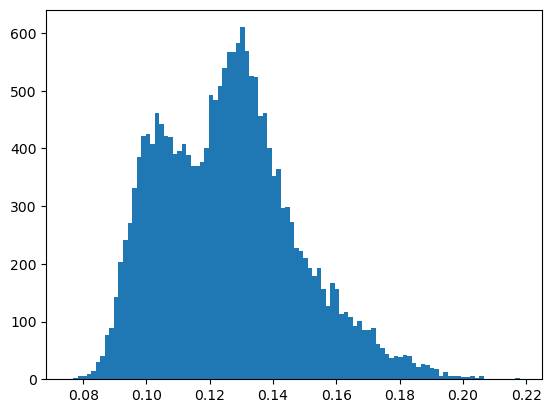

In [39]:
plt.hist(model_early.predict(sim_scenarios.numpy()[100000:120000])['y'], bins = 100)